<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import simpy
import random
import datetime
import numpy as np
import pandas as pd

In [2]:
class G:
    ITERATIONS = 100
    DURATIONS = 6120
    fac_id_df = pd.read_excel("data/FacilityIDLookup.xlsx")
    priv_df = pd.read_excel("data/Privileges.xlsx")
    proc_id_df = pd.read_excel("data/ProcedureIDLookup.xlsx")
    rad_sched_df = pd.read_excel("data/RadiologistSchedules.xlsx")
    restr_df = pd.read_excel("data/Restrictions.xlsx")

In [3]:
def process_data():
    G.rads_list = sorted(G.rad_sched_df["RadiologistID"].unique())
    rads_in_priv = sorted(G.priv_df["RadiologistID"].unique())
    red_priv_df = G.priv_df[G.priv_df["RadiologistID"].isin(G.rads_list)]
    G.radiologist_ids = list(set(rads_in_priv).intersection(set(G.rads_list)))
    G.red_rad_sched_df = G.rad_sched_df[G.rad_sched_df["RadiologistID"].isin(G.radiologist_ids)]
    G.facilities = sorted(red_priv_df["FacilityID"].unique())
    G.procedures_list = sorted(G.proc_id_df["ProcedureID"].unique())
    G.modalities = list(G.proc_id_df.Modality.unique())
    start_time = G.rad_sched_df["Start Time"][0]
    G.rad_sched_df['Relative Start Time'] = (G.rad_sched_df["Start Time"] - start_time)/np.timedelta64(1, 's')/60
    G.rad_sched_df['Relative End Time'] = (G.rad_sched_df["End Time"] - start_time)/np.timedelta64(1, 's')/60
    G.radiologists_by_fac = G.priv_df.groupby("FacilityID")["RadiologistID"].apply(list).reset_index(name='Radiologists').set_index("FacilityID")
    G.facilities_by_rad = G.priv_df.groupby("RadiologistID")["FacilityID"].apply(list).reset_index(name='Facilities').set_index("RadiologistID")

In [4]:
process_data()

In [5]:
G.target_times = {
    1: 10,
    2: 20,
    3: 60
}

G.specialties = {
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5'
}

In [105]:
class MedicalImage(object):    
    def __init__(self, img_id, time_created, urgency, image_type):#, modality, speciality, urgency, image_label):
        self.img_id = img_id
        self.time_created = time_created
        self.urgency = urgency
        self.image_type = image_type
        self.target_time = G.target_times[urgency]
        self.time_remaining = G.target_times[urgency]
        self.in_queues = []   #keep track on which queues image is in [rad_id, position]
        self.time_seen = 0
        self.time_done = 0
        self.rad_seen = "None"
        
    def update_time_remaining(self, t):
        self.time_remaining = self.target_time - (t - self.time_created)
        
        
class Radiologist:
    def __init__(self, rad_id, specialties, working=True):
        self.queue = []
        self.rad_id = rad_id
        self.specialties = specialties
        self.is_working = working
        self.images_served = []
        self.idle_times = []
        self.time_of_last_idle = 0
        self.time_last_not_idle = 0
        self.busy_times = []
        self.time = 0
        self.time_of_step = 0
        self.queue_length = []
        self.service_starts = []
        self.service_ends = []
        self.service_time = []
        
    def get_stats(self):
        return self.idle_times, self.busy_times, self.queue_length, self.service_starts, self.service_ends, self.service_time 
        
    def show_queue(self):
        return self.queue
    
    def add_job(self, med_image, time):
        self.queue.append(med_image)    #each customer is represented by the time it will take for them to be served
        #print(self.show_queue())
        
    def update_queue(self, time):
        for img in self.queue:
            img.update_time_remaining(time)
        #sort_queue()        
    #def sort_queue(self):
               
    def update(self, time, add_cust_bool=False):
        self.time_of_step =  time - self.time
        self.update_queue(time)
        if add_cust_bool:
            self.add_customer(time)
        self.show_queue()
        self.queue_length.append(len(self.queue.elements))
        self.time = time      
        
        
class SystemState:
    def __init__(self, events, images, rads):
        self.time = 0
        self.events = events
        self.images = images
        self.rads = rads
        self.rads_working = rads
        self.rads_not_working = []
        self.events_history = []
        self.queue_lengths = []
        self.time_steps = []
        
    def create_event(self, time, event_type, obj):
        self.events.append([time, event_type, obj])
        self.events = sorted(self.events, key=lambda x: x[0])
        
    def process_event(self):
        event = self.events[0]
        self.events_history.append(event)
        self.time = event[0]       
        event_type = event[1]
        del self.events[0]
        temp_list = []
        for r in self.rads:
            temp_list.append(len(r.queue))
        self.queue_lengths.append(temp_list)
        self.time_steps.append(self.time)
            
        if event_type == "New Job":
            self.distribute_job(event[2])
        elif event_type == "Job Done":
            rad = event[2]
            self.complete_job(rad)
        print("Event processed")
        if len(self.events) > 0:
            self.process_event()
        else:
            print("Simulation complete")
                
    def distribute_job(self, med_image):
        urgency = med_image.urgency
        image_type = med_image.image_type
        capable_rads = []
        for rad in self.rads_working:      #finds radiologists capable of working on image
            if image_type in rad.specialties:
                capable_rads.append(rad)
        for rad in capable_rads:
            rad.add_job(med_image, self.time)
            med_image.in_queues.append(rad)    #keep track of which rads have image in queue
            if len(rad.queue)==1:
                self.start_job(rad)
                break         
        self.update_queues()
        
        
    def update_queues(self):
        for rad in self.rads_working:
            rad.update_queue(self.time)
                
    def start_job(self, rad):
        med_image = rad.queue[0]
        image_type = med_image.image_type
        urgency = med_image.urgency
        rad.service_starts = self.time
        med_image.time_seen = self.time
        med_image.rad_seen = rad.rad_id
        self.events_history.append([self.time, "Job Started", med_image])
        process_time = np.random.exponential(G.target_times[urgency])
        self.create_event(self.time+process_time, "Job Done", rad)
        print(f"Image {med_image.img_id} is seen by radiologist {rad.rad_id} at {self.time}")
        for r in med_image.in_queues:
            if r != rad:
                r.queue.remove(med_image)           
        
    def complete_job(self, rad):
        med_image = rad.queue[0]
        rad.images_served.append(med_image.img_id)
        rad.service_ends.append(self.time)
        med_image.time_done = self.time
        print(f"Image {med_image.img_id} is done by radiologist {rad.rad_id} at {self.time}")
        del rad.queue[0]
        if len(rad.queue) > 0:
            self.start_job(rad)
        
    def run_simulation(self):
        self.process_event()
        
                

In [106]:
arrival_times = []
time = 0
for i in range(180):
    time += np.random.exponential(2)
    arrival_times.append(time)

In [107]:
#arrival_times

In [108]:
med_images = []
for i, t in enumerate(arrival_times):
    med_images.append(MedicalImage(i, t, random.sample(list(G.target_times.keys()), 1)[0], random.sample(list(G.specialties.keys()), 1)[0]))

In [109]:
radiologists = []
for i in range(5):
    specialties_temp = random.sample(list(G.specialties.keys()), random.randrange(2,6))
    radiologists.append(Radiologist(i, specialties_temp))

In [110]:
events=[]
for img in med_images:
    events.append([img.time_created, 'New Job', img])

In [111]:
s = SystemState(events, med_images, radiologists)

In [112]:
s.run_simulation()

Image 0 is seen by radiologist 0 at 0.7367560564694746
Event processed
Image 1 is seen by radiologist 1 at 1.9266531885081482
Event processed
Image 2 is seen by radiologist 3 at 2.1987261033638577
Event processed
Image 3 is seen by radiologist 4 at 3.3261894168521264
Event processed
Event processed
Event processed
Image 6 is seen by radiologist 2 at 7.190193620370917
Event processed
Image 2 is done by radiologist 3 at 8.95109333777511
Image 4 is seen by radiologist 3 at 8.95109333777511
Event processed
Image 1 is done by radiologist 1 at 9.692054648612759
Image 5 is seen by radiologist 1 at 9.692054648612759
Event processed
Image 4 is done by radiologist 3 at 9.858299521564646
Event processed
Image 7 is seen by radiologist 3 at 10.80544273428605
Event processed
Event processed
Event processed
Event processed
Image 6 is done by radiologist 2 at 19.805627482039473
Image 8 is seen by radiologist 2 at 19.805627482039473
Event processed
Image 5 is done by radiologist 1 at 20.797322253824582

Event processed
Image 37 is done by radiologist 0 at 263.3406351238862
Image 53 is seen by radiologist 0 at 263.3406351238862
Event processed
Event processed
Image 51 is done by radiologist 4 at 268.0338489880553
Image 60 is seen by radiologist 4 at 268.0338489880553
Event processed
Image 55 is done by radiologist 2 at 268.462993626593
Image 63 is seen by radiologist 2 at 268.462993626593
Event processed
Event processed
Event processed
Event processed
Image 53 is done by radiologist 0 at 270.35475890920424
Image 57 is seen by radiologist 0 at 270.35475890920424
Event processed
Event processed
Event processed
Image 57 is done by radiologist 0 at 275.2739018338132
Image 58 is seen by radiologist 0 at 275.2739018338132
Event processed
Image 58 is done by radiologist 0 at 277.6112098793813
Image 59 is seen by radiologist 0 at 277.6112098793813
Event processed
Event processed
Event processed
Event processed
Event processed
Event processed
Event processed
Image 59 is done by radiologist 0 at

In [113]:
s.events_history

[[0.7367560564694746, 'New Job', <__main__.MedicalImage at 0x1b6fbe72448>],
 [0.7367560564694746, 'Job Started', <__main__.MedicalImage at 0x1b6fbe72448>],
 [1.9266531885081482, 'New Job', <__main__.MedicalImage at 0x1b6fbe724c8>],
 [1.9266531885081482, 'Job Started', <__main__.MedicalImage at 0x1b6fbe724c8>],
 [2.1987261033638577, 'New Job', <__main__.MedicalImage at 0x1b6fbe72c88>],
 [2.1987261033638577, 'Job Started', <__main__.MedicalImage at 0x1b6fbe72c88>],
 [3.3261894168521264, 'New Job', <__main__.MedicalImage at 0x1b6fae443c8>],
 [3.3261894168521264, 'Job Started', <__main__.MedicalImage at 0x1b6fae443c8>],
 [5.117140946228435, 'New Job', <__main__.MedicalImage at 0x1b6fae44308>],
 [6.974725546914744, 'New Job', <__main__.MedicalImage at 0x1b6fae0dc48>],
 [7.190193620370917, 'New Job', <__main__.MedicalImage at 0x1b6fae0d048>],
 [7.190193620370917, 'Job Started', <__main__.MedicalImage at 0x1b6fae0d048>],
 [8.95109333777511, 'Job Done', <__main__.Radiologist at 0x1b6fbd6ff88>]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

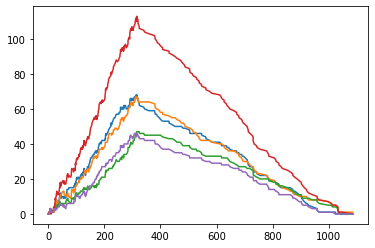

In [114]:
plt.plot(s.time_steps, [item[0] for item in s.queue_lengths])
plt.plot(s.time_steps, [item[1] for item in s.queue_lengths])
plt.plot(s.time_steps, [item[2] for item in s.queue_lengths])
plt.plot(s.time_steps, [item[3] for item in s.queue_lengths])
plt.plot(s.time_steps, [item[4] for item in s.queue_lengths])

In [115]:
s.events

[]

In [178]:
event = s.events[0]
s.time = event[0]       
event_type = event[1]
s.events = s.events[1:]


In [179]:
event

[1.4379278775558813, 'New Job', <__main__.MedicalImage at 0x24e778a1f08>]

In [180]:
if event_type == "New Job":
    s.distribute_job(event[2])
elif event_type == "Start Job":
    rad = event[2][1]
    s.start_job(rad)
    for e in s.events:
        if e[1]=="Start Job":
            if e[2][0]==event[2][0]:
                s = s.events.remove(e)
elif event_type == "Job Done":
    rad = event[2]
    s.complete_job(rad)
s.events_history.append(s.events[0])
print("Event processed")
        

Event processed


In [181]:
s.events

[[1.4379278775558813,
  'Start Job',
 [1.4379278775558813,
  'Start Job',
 [6.702661447651137, 'New Job', <__main__.MedicalImage at 0x24e778a1b88>],
 [8.1831092678645, 'New Job', <__main__.MedicalImage at 0x24e778a1508>],
 [11.93192041849047, 'New Job', <__main__.MedicalImage at 0x24e778c38c8>],
 [13.631487931267504, 'New Job', <__main__.MedicalImage at 0x24e778c35c8>],
 [17.057813124350737, 'New Job', <__main__.MedicalImage at 0x24e778c3888>],
 [23.242267757434373, 'New Job', <__main__.MedicalImage at 0x24e77379608>],
 [25.990419130097276, 'New Job', <__main__.MedicalImage at 0x24e77379a88>],
 [30.060293622532697, 'New Job', <__main__.MedicalImage at 0x24e77379c88>],
 [33.09377149187409, 'New Job', <__main__.MedicalImage at 0x24e77379c48>],
 [33.103031217584096, 'New Job', <__main__.MedicalImage at 0x24e77379948>],
 [34.26800066721298, 'New Job', <__main__.MedicalImage at 0x24e778a9488>],
 [35.47595495608174, 'New Job', <__main__.MedicalImage at 0x24e778a9448>],
 [35.540090355038494, 

In [ ]:
for e in s.events:
    if e[1]=="Start Job":
        if e[2][0]==event[2][0]:
            s.events.remove(e)

In [102]:
s.events[0][2][0]==s.events[1][2][0]

True

In [101]:
event[1][2][0]

'w'

In [36]:
urgency = med_image.urgency
image_type = med_image.image_type
capable_rads = []
for rad in s.rads_working:
    if image_type in rad.specialties:
        capable_rads.append(rad)

In [37]:
capable_rads

In [38]:
s.time

0.4968132561968908

In [46]:
for rad in capable_rads:
    rad.add_job(med_image, s.time)
    med_image.in_queues.append(rad)    #keep track of which rads have image in queue
    if len(rad.queue)==0:  
        print("dafs")
        s.create_event(s.time, "Start Job", rad)
        break

In [48]:
rad.queue

 ...]

In [45]:
len([])

0